In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

start_time = time.time()
# 4 signature configurations for the torus
SS = [[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1, -1, +1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, +1, +1, +1, -1, -1, -1, -1, -1, -1],
      [-1, +1, -1, -1, -1, -1, -1, +1, -1, +1, +1, +1, -1, +1, -1, -1, -1, -1]]
S = SS.copy()
# 1000 random configurations for the 18 qubits.
np.random.seed(1)
S.extend(np.random.choice([-1, 1], size=(1000, 18)))

In [7]:
# Translational symmetry, Real variables.
(ss, tt, N) = (0.01, 200, len(S))
IN = [0.1, 0.6, 0.7, 0.8, 0.9]
BF = torch.tensor([IN[0]], requires_grad=True)
WF = torch.tensor([IN[1], IN[2], IN[3], IN[4]], requires_grad=True)
optimizer = torch.optim.Adam([BF, WF], lr=ss)


# pr is the shortcut for cosh function
def pr(b, w, s1, s2, s3, s4):
    res = torch.cosh(b[0] + 1j * (w[0] * s1 + w[1] * s2 + w[2] * s3 + w[3] * s4))
    return res


# pe is the difference after the application of a face operator
def pe(b, w, s1, s2, s3, s4):
    result = pr(b, w, s1, s2, s3, s4) * (s1 * s2 * s3 * s4) - pr(b, w, s1, s2, s3, s4)
    return result


def criterion(bf, wf):
    V = torch.empty((9 * N,), dtype=torch.complex64)
    for k in range(N):
        V[9 * k + 0] = pe(bf, wf, S[k][4], S[k][6], S[k][3], S[k][0])
        V[9 * k + 1] = pe(bf, wf, S[k][5], S[k][7], S[k][4], S[k][1])
        V[9 * k + 2] = pe(bf, wf, S[k][3], S[k][8], S[k][5], S[k][2])
        V[9 * k + 3] = pe(bf, wf, S[k][10], S[k][12], S[k][9], S[k][6])
        V[9 * k + 4] = pe(bf, wf, S[k][11], S[k][13], S[k][10], S[k][7])
        V[9 * k + 5] = pe(bf, wf, S[k][9], S[k][14], S[k][11], S[k][8])
        V[9 * k + 6] = pe(bf, wf, S[k][16], S[k][0], S[k][15], S[k][12])
        V[9 * k + 7] = pe(bf, wf, S[k][17], S[k][1], S[k][16], S[k][13])
        V[9 * k + 8] = pe(bf, wf, S[k][15], S[k][2], S[k][17], S[k][14])
    v = torch.norm(V)
    return v


# Stochastic gradient descent
COST = []
ABF = []
AWF = [[], [], [], []]
for h in range(tt):
    cost = criterion(BF, WF)
    COST.append(cost.tolist())
    ABF.append(BF[0].tolist())
    for q in range(4):
        AWF[q].append(WF[q].tolist())
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 1427.0835402011871 seconds


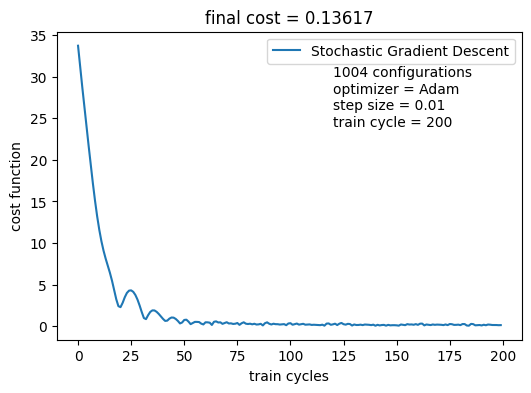

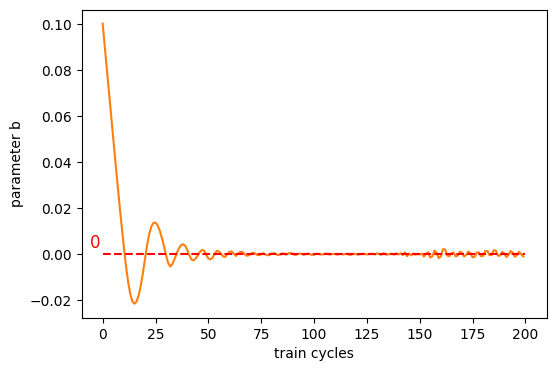

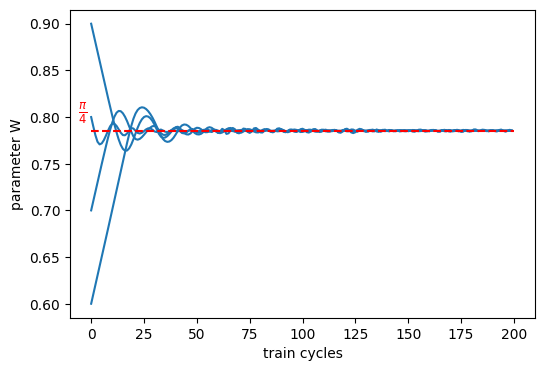

In [10]:
# Visualize results: Cost
fig1 = plt.figure(figsize=(6, 4))
plt.plot(COST, label="Stochastic Gradient Descent")
plt.title("final cost = %.5f" % cost.data.item())
plt.text(0.6*tt, 30, "1004 configurations")
plt.text(0.6*tt, 28, "optimizer = Adam")
plt.text(0.6*tt, 26, "step size = %.2f" % ss)
plt.text(0.6*tt, 24, "train cycle = %i" % tt)
plt.xlabel("train cycles")
plt.ylabel("cost function")
plt.legend()
plt.show()

# Visualize results: BF
fig2 = plt.figure(figsize=(6, 4))
plt.plot(ABF, color='tab:orange')
plt.plot ([0, tt], [0.0, 0.0], 'r--', linewidth=1.5)
plt.text (-0.03*tt, 0.003, '0', color = 'r', fontsize = 12)
plt.xlabel("train cycles")
plt.ylabel("parameter b")
plt.show()

# Visualize results: WF
fig3 = plt.figure(figsize=(6, 4))
for q in range(4):
  plt.plot(AWF[q], color='tab:blue')
plt.plot ([0, tt], [0.7854, 0.7854], 'r--', linewidth=1.5)
plt.text (-0.03*tt, 0.8, r'$\frac{\pi}{4}$', color = 'r', fontsize = 12)
plt.xlabel("train cycles")
plt.ylabel("parameter W")
plt.show()